# 평가 조건
1. 모델과 데이터를 정상적으로 불러오고, 작동하는 것을 확인하였다.
    - klue/bert-base를 pretrained weight 없이 불러와 토큰화된 NSMC 데이터셋을 입력하여 훈련시킬 때, 모델이 정상적으로 작동하는 것을 확인하였다.
2. Preprocessing을 개선하고, fine-tuning을 통해 모델의 성능을 개선시켰다.
    - Validation accuracy를 90% 이상으로 개선하였다.
3. 모델 학습에 Bucketing을 성공적으로 적용하고, 그 결과를 비교분석하였다.
    - Bucketing task을 수행하여 fine-tuning 시 연산 속도와 모델 성능 간의 trade-off 관계가 발생하는지 여부를 확인하고, 분석한 결과를 제시하였다.

# 모듈 임포트

In [66]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

from transformers import DataCollatorWithPadding
import tensorflow as tf
from collections import Counter
import transformers
from datasets import load_dataset
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


import matplotlib.pyplot as plt

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# 1. NSMC 데이터 불러오기

In [67]:
row_dataset = load_dataset('nsmc')

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

In [68]:
row_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

데이터는 총 200000만개로 train 15만개, test 5만개이며, id, document, label로 이루어져 있습니다.

## 데이터 확인하기

In [4]:
train = row_dataset['train']
cols = train.column_names

for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




## 데이터 길이 확인

리뷰의 최소 길이 :0
리뷰의 최대 길이 :146
리뷰의 평균 길이 :35.20335333333333


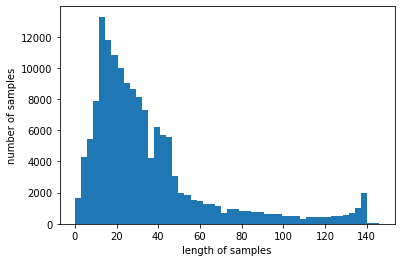

In [5]:
print('리뷰의 최소 길이 :{}'.format(min(len(l) for l in train['document'])))
print('리뷰의 최대 길이 :{}'.format(max(len(l) for l in train['document'])))
print('리뷰의 평균 길이 :{}'.format(sum(map(len, train['document']))/len(train['document'])))

plt.hist([len(s) for s in train['document']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
for l, v in enumerate(train['document']):
    if len(v) == 0:
        print(l)

25857
55737
110014
126782
140721


In [7]:
train['document'][25857]

''

길이가 0인 데이터는 아무것도 없는 데이터인것을 확인하였습니다.

해당 데이터는 추후 전처리에서 제거해주도록 하겠습니다.

## 타겟 데이터 확인

In [8]:
result = Counter(train['label']).values()
print(result)

dict_values([75173, 74827])


0(부정)인 데이터가 75,173개, 1(긍정)인 데이터가 74,827개가 있으므로 밸런스한 데이터인것을 확인할 수 있습니다.

# 2. huggingface에서 model 및 tokenizer 불러오기
huggingface에서 사전학습된 모델을 불러옵니다.

저는 klue/bert 모델과 klue/roberta 모델을 불러와서 두 모델의 성능을 비교해보도록 하겠습니다.

In [9]:
bert_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
bert_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [69]:
roberta_tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')
roberta_model = AutoModelForSequenceClassification.from_pretrained('klue/roberta-base', num_labels = 2)

loading file https://huggingface.co/klue/roberta-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/e8441a174492958462b6b16b6db8f1e7253cd149ca779522cadd812d55091b89.d1b86bed49516351c7bb29b19d7e7be2ab53b931bcb1f9b2aacfb71f2124d25a
loading file https://huggingface.co/klue/roberta-base/resolve/main/tokenizer.json from cache at /aiffel/.cache/huggingface/transformers/233a5b2c17873a8477b62dd92a02092a9937759e924a5f22b111becebb8aba5e.44c30ade4958fcfd446e66025e10a5b380cdd0bbe9b3fb7a794f357e7f0f34c2
loading file https://huggingface.co/klue/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/klue/roberta-base/resolve/main/special_tokens_map.json from cache at /aiffel/.cache/huggingface/transformers/9d0c87e44b00acfbfbae931b2e4068eb6311a0c3e71e23e5400bdf57cab4bfbf.70c17d6e4d492c8f24f5bb97ab56c7f272e947112c6faf9dd846da42ba13eb23
loading file https://huggingface.co/klue/roberta-base/resolve/main/tokenizer_config.json from 

# 3. 데이터 전처리
길이가 0인 데이터를 제거해주도록 하겠습니다.

In [59]:
row_dataset = row_dataset.filter(lambda x: len(x['document']) > 0)
row_dataset

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-b626d26578c9f24a.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-f1144a1c5e8f9fce.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 149995
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 49997
    })
})

최종 train data는 149,995개 / test data는 49,997개 입니다.

다만 해당 데이터를 모두 사용하면 학습과 추론에 상당한 시간이 걸리기 때문에 train 50,000개 / test 10,000개를 추출하여 사용하도록 하겠습니다.

In [12]:
def bert_transform(data):
    return bert_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

bert_row_dataset = row_dataset.map(bert_transform, batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [48]:
def roberta_transform(data):
    return roberta_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

roberta_row_dataset = row_dataset.map(roberta_transform, batched=True)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-f84ed4a324e82307.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [14]:
bert_train_dataset = bert_row_dataset['train'].shuffle(random_seed).select(range(50000))
bert_test_dataset = bert_row_dataset['test'].shuffle(random_seed).select(range(10000))

In [15]:
bert_train_dataset, bert_val_dataset= bert_train_dataset.train_test_split(test_size=0.2).values()

In [16]:
bert_val_dataset

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 10000
})

In [17]:
roberta_train_dataset = roberta_row_dataset['train'].shuffle(random_seed).select(range(50000))
roberta_test_dataset = roberta_row_dataset['test'].shuffle(random_seed).select(range(10000))

In [18]:
roberta_train_dataset, roberta_val_dataset= roberta_train_dataset.train_test_split(test_size=0.2).values()

In [19]:
roberta_val_dataset

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 10000
})

# 4. model 학습

In [20]:
output_dir = os.getenv('HOME')+'/aiffel/going_deeper/model'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [21]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [22]:
metric

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

## 4-1. bert model 학습

In [23]:
bert_trainer = Trainer(
    model=bert_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=bert_train_dataset,    # training dataset
    eval_dataset=bert_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

bert_trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 40000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.333900,0.325958,0.886500
2,0.233400,0.398353,0.890800
3,0.128100,0.545082,0.889300


Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-500
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-1000
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-1500
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-2000
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-2000/pytorch_m

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=15000, training_loss=0.24248295389811197, metrics={'train_runtime': 13219.5427, 'train_samples_per_second': 9.077, 'train_steps_per_second': 1.135, 'total_flos': 3.15733266432e+16, 'train_loss': 0.24248295389811197, 'epoch': 3.0})

In [24]:
bert_trainer.evaluate(bert_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


{'eval_loss': 0.5151875019073486,
 'eval_accuracy': 0.8946,
 'eval_runtime': 389.0046,
 'eval_samples_per_second': 25.707,
 'eval_steps_per_second': 3.213,
 'epoch': 3.0}

## 4-2. roberta 학습

In [25]:
roberta_trainer = Trainer(
    model=roberta_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=roberta_train_dataset,    # training dataset
    eval_dataset=roberta_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

roberta_trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 40000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.336500,0.290169,0.886900
2,0.264600,0.394025,0.892700
3,0.182900,0.457633,0.895600


Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-500
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-1000
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-1500
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-2000
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-2000/pytorch_m

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=15000, training_loss=0.275982410176595, metrics={'train_runtime': 13575.9804, 'train_samples_per_second': 8.839, 'train_steps_per_second': 1.105, 'total_flos': 3.15733266432e+16, 'train_loss': 0.275982410176595, 'epoch': 3.0})

In [26]:
roberta_trainer.evaluate(roberta_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


{'eval_loss': 0.44005903601646423,
 'eval_accuracy': 0.8983,
 'eval_runtime': 382.0675,
 'eval_samples_per_second': 26.173,
 'eval_steps_per_second': 3.272,
 'epoch': 3.0}

## 4-3. 추가적인 성능 향상 시도
BERT모델과 ROBERTA 모델 중 ROBERTA의 성능이 더 좋아 해당 모델을 이용하여 추가적인 성능 향상 시도를 해보겠습니다.
1. data_collator 추가 
2. 파라미터 변경 및 추가
    - warmup_ratio 변수 추가
    - group_by_length 변수 추가

In [65]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [70]:
def roberta_transform(data):
    return roberta_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

roberta_row_dataset = row_dataset.map(roberta_transform, batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [71]:
roberta_train_dataset = roberta_row_dataset['train'].shuffle(random_seed).select(range(50000))
roberta_test_dataset = roberta_row_dataset['test'].shuffle(random_seed).select(range(10000))

roberta_train_dataset, roberta_val_dataset= roberta_train_dataset.train_test_split(test_size=0.2).values()

In [72]:
output_dir = os.getenv('HOME')+'/aiffel/going_deeper/model'

data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    warmup_ratio = 0.1,
    group_by_length = True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [73]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    m1 = load_metric('accuracy')
    m2 = load_metric('f1')

    acc = m1.compute(predictions=preds, references=labels)['accuracy']
    f1 = m2.compute(predictions=preds, references=labels)['f1']

    return {'accuracy':acc, 'f1':f1}

In [74]:
roberta_trainer = Trainer(
    model=roberta_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=roberta_train_dataset,    # training dataset
    eval_dataset=roberta_val_dataset,       # evaluation dataset
    data_collator = data_collator,
    compute_metrics=compute_metrics,
)

roberta_trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 40000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.339500,0.348361,0.885100,0.879975
2,0.291200,0.396007,0.893800,0.893651
3,0.180300,0.458208,0.896300,0.896290


Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-500
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-1000
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-1500
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/going_deeper/model/checkpoint-2000
Configuration saved in /aiffel/aiffel/going_deeper/model/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/going_deeper/model/checkpoint-2000/pytorch_m

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=15000, training_loss=0.2873779469807943, metrics={'train_runtime': 13309.4524, 'train_samples_per_second': 9.016, 'train_steps_per_second': 1.127, 'total_flos': 3.15733266432e+16, 'train_loss': 0.2873779469807943, 'epoch': 3.0})

In [75]:
roberta_trainer.evaluate(roberta_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


{'eval_loss': 0.42159461975097656,
 'eval_accuracy': 0.9017,
 'eval_f1': 0.9029902299417744,
 'eval_runtime': 340.9479,
 'eval_samples_per_second': 29.33,
 'eval_steps_per_second': 3.666,
 'epoch': 3.0}

# 5. 결과 비교
|  model  |data_collator|group_by_length|   time   |val accuracy|val F1-Score|test accuracy|test F1-Score|
|---------|-------------|---------------|----------|------------|------------|-------------|-------------|
|   BERT  |      x      |       x       | 3:40:18  |    88.93   |      -     |    89.46    |      -      |
|RoBERTa_1|      x      |       x       | 3:46:14  |    89.56   |      -     |    89.83    |      -      |
|RoBERTa_2|      o      |       o       | 3:41:48  |    89.63   |   89.63    | __90.17__  |__90.30__   |

Hugging Face를 이용하여 BERT, RoBERTa 모델과 토크나이저를 불러와 NSMC 데이터를 학습하고 해당 모델의 성능을 비교하였습니다. BERT와 RoBERTa는 동일한 파라미터를 통하여 실험을 하였으며, RoBERTa의 성능이 BERT보다 좋다는 것을 확인하였습니다. 그 후 RoBERTa를 이용하여 추가적인 성능향상을 시도하였습니다. data_collator와 group_by_length 변수를 활용하였는데, 해당 변수를 사용하였을때 시간을 줄어들고, 성능은 약간 개선되는 것을 확인할 수 있었습니다. data_collator와 group_by_length 데이터들 간의 길이를 이용하여 데이터를 모델에 효율적으로 제공하는 역할을 하기 때문에 성능과 속도 측면에서 개선된것으로 생각됩니다. 또한 모든 데이터를 사용하여 실험을 했다면, 성능은 더 올랐을것으로 생각됩니다.

group_by_length
- 데이터 배치를 길이에 따라 자동으로 그룹화하여 데이터 로딩 및 배치 생성 과정에서 각 배치의 텍스트 시퀀스 길이가 유사한 데이터끼리 그룹으로 묶이도록 하는 기능을 담당

장점
1. 메모리 효율성: 텍스트 시퀀스의 길이가 다양한 경우, 길이가 유사한 데이터끼리 배치를 구성하면 메모리를 더 효율적으로 사용할 수 있습니다. 길이가 유사한 데이터끼리 배치를 구성하면 각 배치의 패딩이 최소화되어 메모리 사용량이 줄어들고, 학습 속도가 향상될 수 있습니다.

2. 학습 효율성: 길이가 유사한 데이터끼리 배치를 구성하면 학습 속도가 향상될 수 있습니다. 각 배치의 텍스트 시퀀스 길이가 유사하면 GPU에서 병렬로 연산을 수행하는 데 효율적이며, 데이터 로딩과 배치 생성 시간이 줄어들어 전체 학습 시간을 단축시킬 수 있습니다.

3. 학습 안정성: 길이가 크게 다른 데이터를 섞어서 배치를 구성하면 학습이 불안정해질 수 있습니다. 길이가 다른 데이터를 함께 배치로 구성하면 작은 시퀀스가 긴 시퀀스에 의해 연산이 지연될 수 있고, 학습이 불균형하게 진행될 수 있습니다. 이에 반해 길이가 유사한 데이터끼리 배치를 구성하면 학습이 안정적으로 진행될 가능성이 높아집니다.


Data Collator
- Data Collator는 데이터셋에서 가져온 샘플들을 그룹화하고 전처리하는 기능을 담당

장점
1. 배치 처리: Data Collator는 데이터셋으로부터 미니배치(mini-batch)를 생성하는 역할을 합니다. 데이터를 모델에 효율적으로 공급하기 위해 여러 샘플을 하나의 배치로 묶어주는 작업을 담당합니다. 이를 통해 GPU 또는 TPU와 같은 가속화 장치를 최대한 활용하여 병렬 처리를 수행할 수 있습니다.

2. 패딩 처리: Data Collator는 데이터셋의 시퀀스를 패딩하여 일괄적인 길이로 맞춰줍니다. 시퀀스 길이가 다른 데이터를 배치로 처리하려면 길이가 가장 큰 시퀀스에 맞춰서 패딩을 추가해야 합니다. Data Collator는 이러한 패딩 작업을 자동으로 처리하여 배치 내 모든 시퀀스의 길이를 동일하게 맞출 수 있습니다.

3. 특수 토큰 추가: Data Collator는 특수 토큰(예: 문장 시작, 문장 종료, 패딩)을 시퀀스에 추가하는 작업을 수행합니다. 이러한 특수 토큰은 모델에게 문장 구조를 인식하고 처리하는 데 도움을 줍니다.

4. 사용자 정의 처리: Data Collator를 사용하면 사용자가 원하는 대로 데이터를 처리할 수 있습니다. 예를 들어, 어휘 사전을 기반으로 정수 인코딩을 수행하거나, 토큰화된 데이터를 인코딩할 때 사용자가 추가적인 전처리를 수행할 수 있습니다.

Data Collator의 이점은 데이터를 효율적으로 처리하고 모델 학습에 필요한 데이터 배치를 생성하는 데 있습니다. 이를 통해 학습 과정의 속도와 안정성을 향상시킬 수 있고, 모델의 성능을 개선할 수 있습니다.

# 전체 회고
- 허깅페이스를 오랜만에 다뤄본것 같아 재밌었습니다.
- exploration 당시에도 해당 데이터를 이용하여 딥러닝으로 test set 기준 accuracy 85%를 넘었지만, 이번 과제에서는 사전학습 모델을 이용하여 90%를 넘었습니다.
- 사전학습 모델의 강력함을 다시 한번 느낀 계기가 되었습니다. 
- 아이펠톤이라고 생각하고 이것저것 많이 찾아보고 시도해보고자 하였습니다.
- 하지만 학습을 시키는데 시간이 많이 걸려서 여러가지 실험을 많이 못해본것이 아쉽습니다.
- 그동안 진행했던 과제들을 다시 한번 살펴보면서 아이펠톤을 준비해야겠다는 생각이 많이 들었습니다.
- 잘 준비해서 앞으로 있을 과제를 잘 마무리하고 싶습니다.

# 참고자료

- https://huggingface.co/klue/bert-base
- https://huggingface.co/klue/roberta-base
- 이전 노드